## FCNN with a boolean output indicating the likelihood of the image containing nerve

In [3]:
import sys
sys.path.append('../notebooks')
import utils
import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')
%matplotlib inline

In [4]:
_d = np.load('../data/data_clean_128_train.npz')
X = _d['X']
Y = _d['Y']

# Turn labels into boolean present/missing
Y_binary = np.sum(np.sum(Y, axis=2), axis=1) > 0
Y_binary = Y_binary.astype(np.float32)

In [5]:
# Also load the non-filtered data for evaluation
_d = np.load('../data/data_128_train.npz')
X_full = _d['X'][:,None,:,:]
Y_full = _d['Y'][:,None,:,:]

In [6]:
print X.shape
print Y.shape

(3906, 128, 128)
(3906, 128, 128)


In [7]:
nsamples = X.shape[0]

train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.1)
#train_indices, test_indices = train_test_split(np.arange(nsamples), test_size=0.25)
X_train = X[train_indices][:,None,:,:]
Y_train_binary = Y_binary[train_indices][:,None]
Y_train = Y[train_indices][:,None,:,:]
X_test = X[test_indices][:,None,:,:]
Y_test_binary = Y_binary[test_indices][:,None]
Y_test = Y[test_indices][:,None,:,:]

In [8]:
print X_train.shape
print Y_train.shape
print Y_train_binary.shape
print X_train.min(), X_train.max()

(3515, 1, 128, 128)
(3515, 1, 128, 128)
(3515, 1)
0.0 1.0


/home/julien/kaggle/venv/local/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


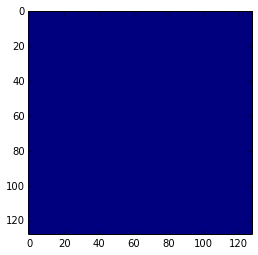

In [9]:
#pl.imshow(X_train[0].squeeze())
pl.imshow(Y_train[0].squeeze())

# Keras model

In [10]:
# channels first in keras
input_shape = X_train[0].shape
print input_shape

(1, 128, 128)


In [11]:
os.environ['KERAS_BACKEND'] = 'theano'
# TODO: Use float16 ?
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float16'
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, merge, RepeatVector, Permute, Reshape
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import LeakyReLU
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras.utils.layer_utils import print_summary
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 4007)


In [12]:
import theano
print theano.config.device

gpu0


In [13]:
input_img = Input(shape=input_shape)
x = Convolution2D(16, 7, 7, border_mode='same')(input_img)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
pool1 = x = Dropout(0.25, name='pool1')(x)

x = Convolution2D(16, 5, 5, border_mode='same')(pool1)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
pool2 = x = Dropout(0.1, name='pool2')(x)

x = Convolution2D(16, 5, 5, border_mode='same')(pool2)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
pool3 = x = Dropout(0.1, name='pool3')(x)

# -- binary presence part
x = Convolution2D(16, 5, 5, border_mode='valid')(pool3)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
pool4 = x = Dropout(0.1, name='pool4')(x)

x = Convolution2D(16, 3, 3, border_mode='valid')(pool4)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2))(x)
pool5 = x = Dropout(0.1, name='pool5')(x)

# Since some images have not mask, the hope is that the innermost units capture this
x = Flatten()(pool5)
x = Dense(32)(x)
x = LeakyReLU()(x)
x = Dense(16)(x)
x = LeakyReLU()(x)
outbin = Dense(1, activation='sigmoid', name='outbin')(x)

# -- location map
x = Convolution2D(16, 3, 3, border_mode='same')(pool3)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool2], mode='concat', concat_axis=1)
x = Convolution2D(16, 3, 3, border_mode='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

x = merge([x, pool1], mode='concat', concat_axis=1)
x = Convolution2D(16, 5, 5, border_mode='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)

outmap = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same', name='outmap')(x)

model = Model(
    input=input_img,
    output=[outmap, outbin]
)

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss='binary_crossentropy')
#rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
#model.compile(optimizer=rmsprop, loss='binary_crossentropy')
model.compile(optimizer='adam', loss='binary_crossentropy',
              loss_weights=[1., 0.01])

print_summary(model.layers)

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_1 (InputLayer)               (None, 1, 128, 128) 0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)    (None, 16, 128, 128)800         input_1[0][0]                    
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)            (None, 16, 128, 128)0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)      (None, 16, 64, 64)  0           leakyrelu_1[0][0]                
___________________________________________________________________________________________

In [14]:
#from IPython.display import SVG
#from keras.utils.visualize_util import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

#from keras.utils.visualize_util import plot
#plot(model, to_file='model.png')

Train on 3515 samples, validate on 391 samples
Epoch 1/10
3515/3515 [==============================] - 25s - loss: 0.0167 - outmap_loss: 0.0157 - outbin_loss: 0.0974 - val_loss: 0.0238 - val_outmap_loss: 0.0188 - val_outbin_loss: 0.4957
Epoch 2/10
3515/3515 [==============================] - 16s - loss: 0.0169 - outmap_loss: 0.0159 - outbin_loss: 0.0954 - val_loss: 0.0236 - val_outmap_loss: 0.0187 - val_outbin_loss: 0.4908
Epoch 3/10
3515/3515 [==============================] - 19s - loss: 0.0166 - outmap_loss: 0.0157 - outbin_loss: 0.0930 - val_loss: 0.0239 - val_outmap_loss: 0.0187 - val_outbin_loss: 0.5164
Epoch 4/10
3515/3515 [==============================] - 27s - loss: 0.0167 - outmap_loss: 0.0158 - outbin_loss: 0.0966 - val_loss: 0.0240 - val_outmap_loss: 0.0189 - val_outbin_loss: 0.5094
Epoch 5/10
3515/3515 [==============================] - 28s - loss: 0.0167 - outmap_loss: 0.0158 - outbin_loss: 0.0926 - val_loss: 0.0234 - val_outmap_loss: 0.0185 - val_outbin_loss: 0.4902
Epo

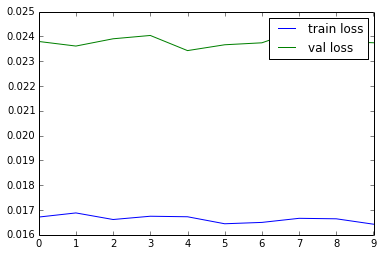

In [35]:
if True:
    json_string = model.to_json()
    open('architecture.json', 'w').write(json_string)
    
    model_checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True, verbose=True)
    
    history = model.fit(
        X_train,
        {'outmap': Y_train, 'outbin': Y_train_binary},
        batch_size=128,
        validation_data=(X_test, {'outmap': Y_test, 'outbin': Y_test_binary}),
        nb_epoch=80,# 40 + 10 + 10 + 5 + 5
        verbose=1,
        shuffle=True,
        callbacks=[model_checkpoint]
    )
    pl.plot(history.history['loss'], label='train loss')
    pl.plot(history.history['val_loss'], c='g', label='val loss')
    pl.legend()
else:
    model_dir = '.'
    model = model_from_json(open(os.path.join(model_dir, 'architecture.json')).read())
    model.load_weights(os.path.join(model_dir, 'weights.hdf5'))
    model.compile(optimizer='adagrad', loss='mse')
    
    print_summary(model.layers)

In [36]:
if False:
    model_dir = '.'
    json_string = model.to_json()
    open(os.path.join(model_dir, 'architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join(model_dir, 'weights.hdf5'))

In [68]:
def predict(X):
    Y_pred, Y_pred_binary = model.predict(X)
    Y_pred_binary = Y_pred_binary.squeeze()
    Y_pred_proba = Y_pred
    Y_pred = Y_pred > 0.3
    for i in range(Y_pred.shape[0]):
        # Clear prediction where we detect to little pixels
        # Figure it out by
        # pl.hist(np.sum(np.sum(np.sum(Y_pred, axis=1), axis=1), axis=1))
        if np.sum(Y_pred[i]) < 100 or Y_pred_binary[i] < 0.3:
            Y_pred[i,:] = 0
    return Y_pred, Y_pred_proba

Y_pred, Y_pred_proba = predict(X_test)
Y_full_pred, Y_full_pred_proba = predict(X_full)

print "test set score : ", utils.dice_coefficient(Y_pred, Y_test)
print "full set score : ", utils.dice_coefficient(Y_full_pred, Y_full)

test set score :  0.673819010558
full set score :  0.67156350093


In [64]:
# Find the images with lowest scores
dice_scores = []
for i in range(Y_full_pred.shape[0]):
    dice_scores.append(utils.dice_coefficient(Y_full_pred[i], Y_full[i]))
dice_scores = np.array(dice_scores)
lowest = np.argsort(dice_scores)

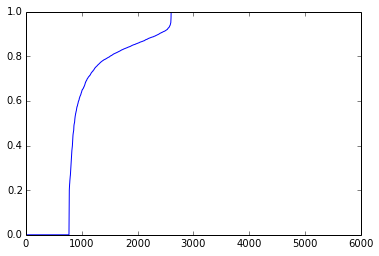

In [65]:
pl.plot(dice_scores[lowest])
#pl.plot(Y_pred_binary[lowest], c='r')

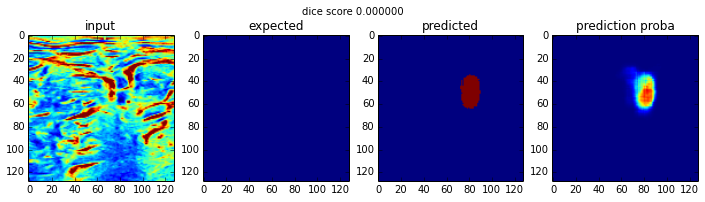

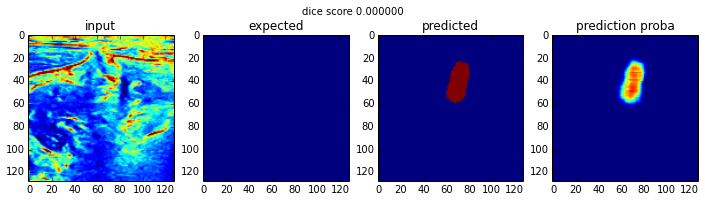

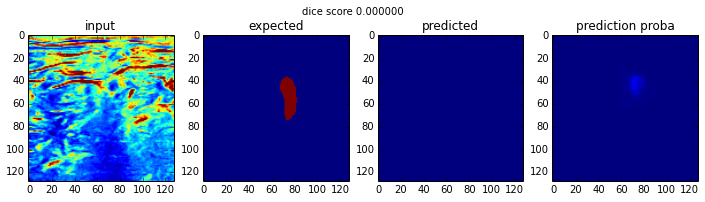

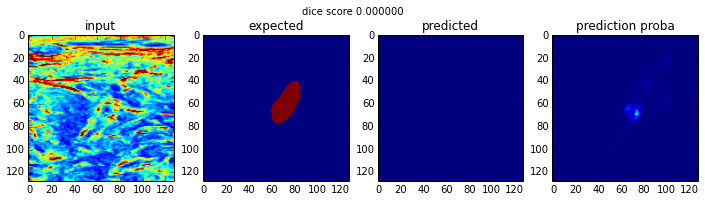

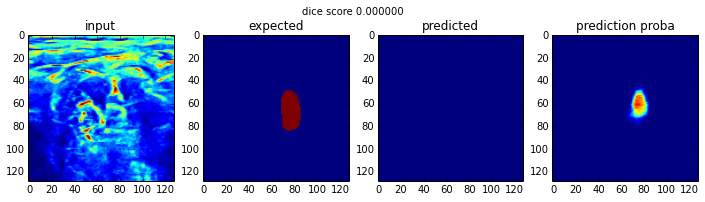

In [66]:
#i = 50
#i = 47

#for i in lowest[2000:2005]:
for i in lowest[:5]:
    pl.figure(figsize=(12, 3))
    pl.suptitle('dice score %f' % utils.dice_coefficient(Y_full_pred[i], Y_full[i]))
    pl.subplot(141)
    pl.title('input')
    pl.imshow(X_full[i].squeeze())
    pl.subplot(142)
    pl.title('expected')
    pl.imshow(Y_full[i].squeeze())
    pl.subplot(143)
    pl.title('predicted')
    pl.imshow(Y_full_pred[i].squeeze(), vmin=0, vmax=1)
    pl.subplot(144)
    
    pl.title('prediction proba')
    pl.imshow(Y_full_pred_proba[i].squeeze(), vmin=0, vmax=1)

# Run the model on kaggle'7 test set

In [42]:
if True:
    _d = np.load('../data/data_128_test.npz')
    X_submit = _d['X']
    test_fnames = _d['test_fnames']
    Y_pred, Y_pred_proba = predict(X_submit[:,None,:,:])

    OUTDIR='../../preds'
    if os.path.exists(OUTDIR):
        shutil.rmtree(OUTDIR)
    utils.mkdir_p(OUTDIR)

    for i in range(Y_pred.shape[0]):
        imre = cv2.resize((Y_pred[i].squeeze() * 255).astype(np.uint8), (580, 420))
        basename = os.path.splitext(test_fnames[i])[0]
        cv2.imwrite(os.path.join(OUTDIR, basename + '.png'), imre)

# Visualize filters

See http://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [43]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [44]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [45]:
import keras.backend as K

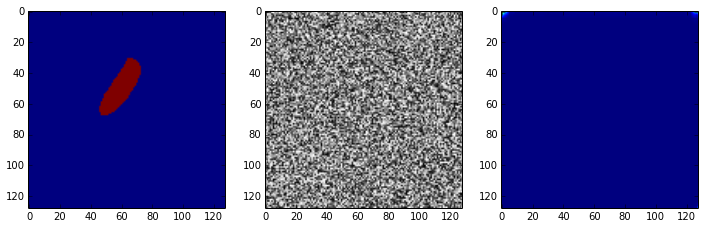

In [69]:
# Dream for the classifmap output
def dream_output(output):
    layer_output = layer_dict['outmap'].output
    # minimize difference between requested output and actual
    loss = K.mean(K.square(output[None,:,:,:] - layer_output))

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([K.learning_phase(), input_img], [loss, grads])

    # we start from a gray image with some noise
    input_img_data = np.random.random((1, input_shape[0], input_shape[1], input_shape[2])) * 0.2 + 0.5
    input_img_data = input_img_data.astype(np.float32)

    orig_img = input_img_data.copy()
    
    step = 0.1
    for i in range(20):
        # 0 is to disable training_phase
        loss_value, grads_value = iterate([0, input_img_data])
        input_img_data -= grads_value * step
        
        # normalize to 0-1
        #input_img_data = (input_img_data - input_img_data.min()) / (input_img_data.max() - input_img_data.min())

    img = input_img_data[0].squeeze()
    # run the image through the model to get prediction
    pred_map, binary_pred = model.predict(img[None,None,:,:])
    return img, pred_map

i = 15
img, pred_map = dream_output(Y_full[i])
pl.figure(figsize=(12, 4))
pl.subplot(131)
pl.imshow(Y_full[i].squeeze())
pl.subplot(132)
pl.imshow(img, cmap=cm.gray)
pl.subplot(133)
pl.imshow(pred_map.squeeze())

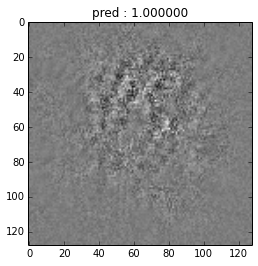

In [52]:
# Dream for the binary output
def dream_binoutput(output):
    
    layer_output = layer_dict['outbin'].output
    # minimize difference between requested output and actual
    loss = K.mean(K.square(output - layer_output[:, 0]))

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([K.learning_phase(), input_img], [loss, grads])

    # we start from a gray image with some noise
    input_img_data = np.random.random((1, input_shape[0], input_shape[1], input_shape[2])) * 0.2 + 0.5
    input_img_data = input_img_data.astype(np.float32)

    orig_img = input_img_data.copy()

    
    step = 0.1
    for i in range(20):
        # 0 is to disable training_phase
        loss_value, grads_value = iterate([0, input_img_data])
        input_img_data -= grads_value * step
        
        # normalize to 0-1
        #input_img_data = (input_img_data - input_img_data.min()) / (input_img_data.max() - input_img_data.min())

    img = input_img_data[0].squeeze()
    # run the image through the model to get prediction
    _, model_pred = model.predict(img[None,None,:,:])
    return img, model_pred

img, model_pred = dream_binoutput(1)
pl.title('pred : %f' % model_pred)
pl.imshow(img, cmap=cm.gray)

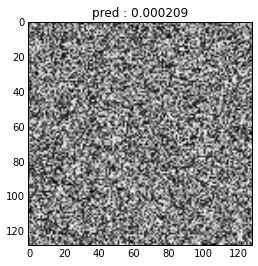

In [53]:
img, model_pred = dream_binoutput(0)
pl.title('pred : %f' % model_pred)
pl.imshow(img, cmap=cm.gray)

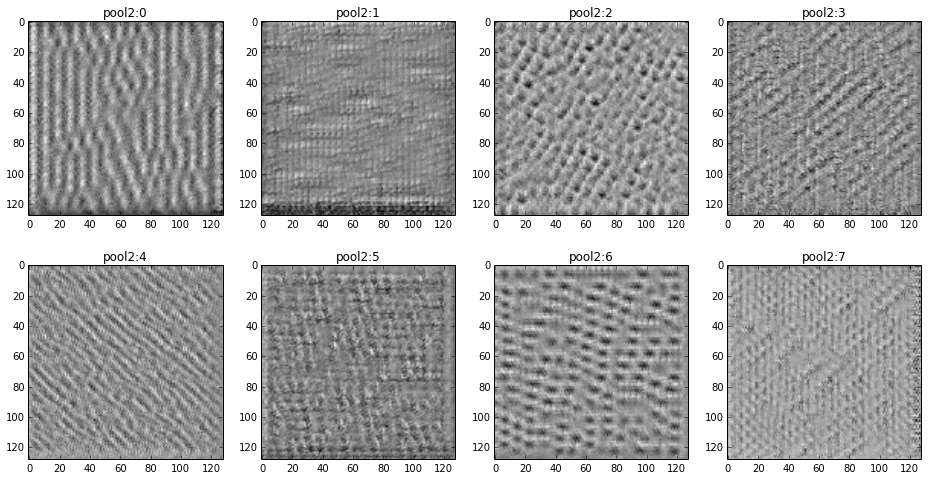

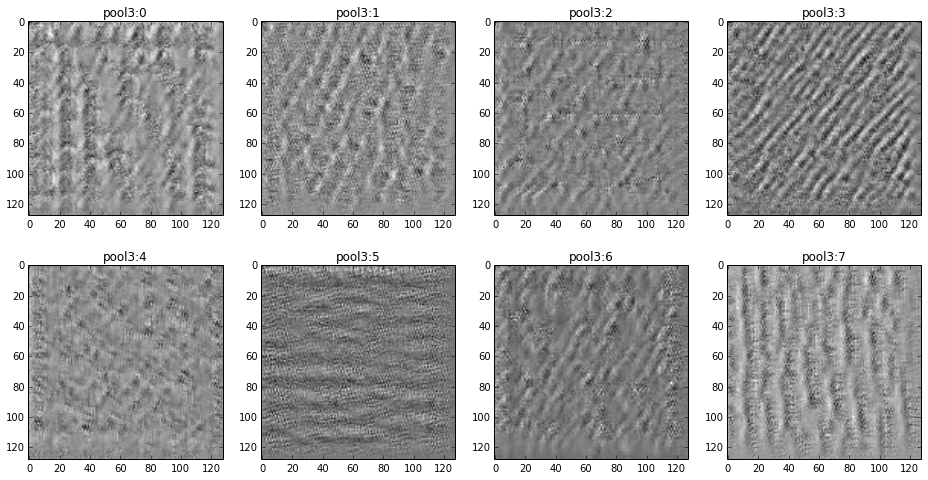

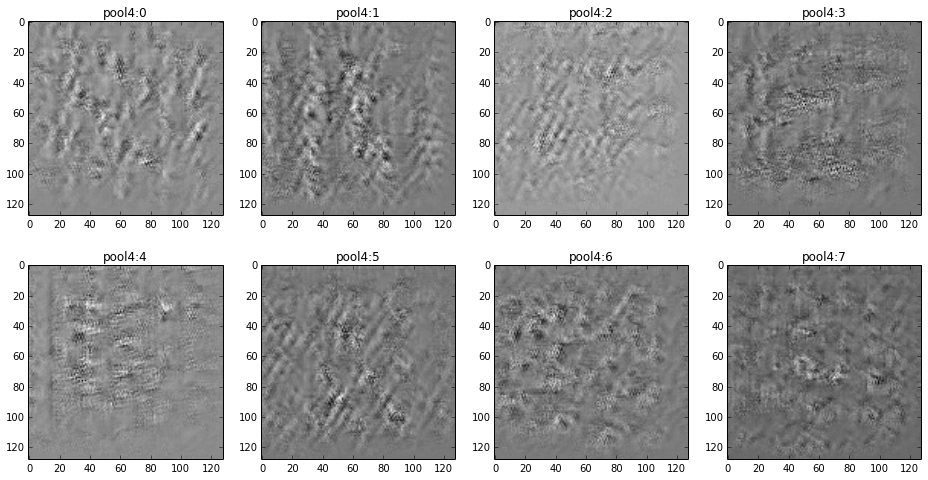

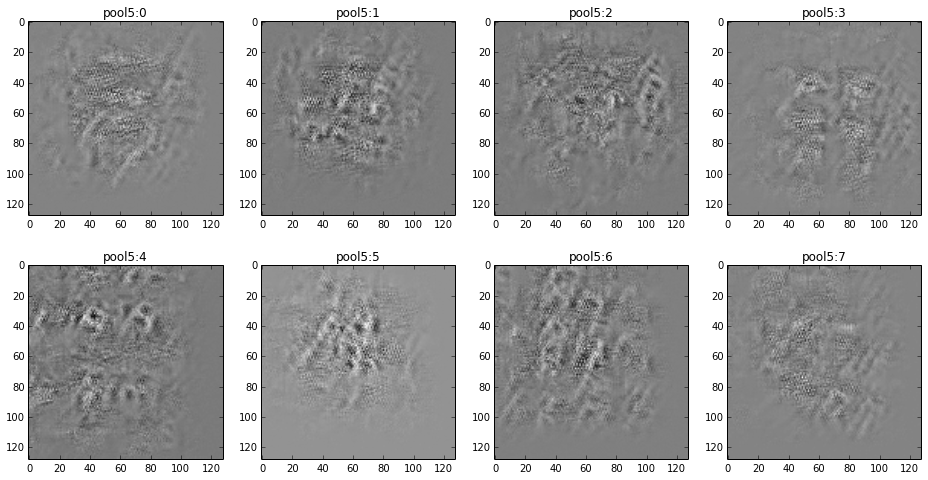

In [67]:
def dream_layer_filter(layer_name, filter_index):

    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, filter_index, :, :])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([K.learning_phase(), input_img], [loss, grads])

    # we start from a gray image with some noise
    input_img_data = np.random.random((1, input_shape[0], input_shape[1], input_shape[2])) * 0.2 + 0.5
    input_img_data = input_img_data.astype(np.float32)

    orig_img = input_img_data.copy()

    # run gradient ascent for 20 steps
    step = 0.1
    for i in range(20):
        # 0 is to disable training_phase
        loss_value, grads_value = iterate([0, input_img_data])
        input_img_data += grads_value * step

        # normalize to 0-1
        #input_img_data = (input_img_data - input_img_data.min()) / (input_img_data.max() - input_img_data.min())

    img = input_img_data[0].squeeze()
    return img
    #img = deprocess_image(img)
    
    
for layer_name in ['pool2', 'pool3', 'pool4', 'pool5']:
    pl.figure(figsize=(16, 8))
    for i in range(8):
        pl.subplot(2, 4, i + 1)
        pl.title('%s:%d' % (layer_name, i))
        img = dream_layer_filter(layer_name, i)
        pl.imshow(img, cmap=cm.gray)